In [ ]:
from openai import OpenAI
# 设置 API 密钥和组织
api_key = ""
client = OpenAI(api_key=api_key)

# 设置组织信息
client.organization = ""

In [76]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor

# 定义文件路径
root_folder = '/Users/zhaorunping/Desktop/Research_Onging/2410_LSE_Xue/data/raw_data_tales'
all_files = []

# 遍历目录，收集所有文件路径
for dirpath, _, filenames in os.walk(root_folder):
    for filename in filenames:
        relative_path = os.path.join(*dirpath.split(os.sep)[-2:], filename)
        all_files.append((os.path.join(dirpath, filename), relative_path))

# 随机选取100个文件
sample_size = min(len(all_files), 100)
selected_files = [all_files[i] for i in np.random.choice(len(all_files), sample_size, replace=False)]

# 读取文件内容并存储
def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()
file_contents = {relative_path: read_file(file_path) for file_path, relative_path in selected_files}

# 初始化文件评分字典
scores = defaultdict(int)
file_pairs = [(selected_files[i][1], selected_files[j][1]) for i in range(len(selected_files)) for j in range(i + 1, len(selected_files))]

# 文件内容比较函数
def compare_files(file_pair):
    file1, file2 = file_pair
    file1_content = file_contents[file1]
    file2_content = file_contents[file2]
    prompt = f"你是一位精通中国民间故事研究的研究员。我们需要研究和诚实相关主题的故事--具体而言，“诚实”指言行跟内心思想一致(指好的思想行为)；不虚假。以下有两段文本，请判断哪一段与“诚实”主题的相关性更强。\n\n文本1：\n{file1_content}\n\n文本2：\n{file2_content}\n\n请直接回答“文本1”或“文本2”，不要输出其他文字。"
    
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            max_tokens=3,
            temperature=0.1,
            top_p=0.9
        )
        answer = response.choices[0].message.content.strip()
        return file_pair, answer
    except Exception as e:
        print(f"Error processing {file_pair}: {e}")
        return file_pair, "Error"

# 多线程处理文件对
with ThreadPoolExecutor(max_workers=8) as executor:
    results = list(tqdm(executor.map(compare_files, file_pairs), total=len(file_pairs), desc="比较文件"))

# 更新评分
for (file1, file2), result in results:
    if result == "文本1":
        scores[file1] += 1
    elif result == "文本2":
        scores[file2] += 1

# 保存结果到 CSV
sample_results = [{"文件路径": file, "内容": file_contents[file], "评分": scores[file]} for file in file_contents]
sample_df = pd.DataFrame(sample_results)
sample_df.to_csv('/Users/zhaorunping/Desktop/Research_Onging/2410_LSE_Xue/result/241027gpt_sample_scores_chengxin.csv', index=False, encoding='utf-8-sig')
print("抽样文件的评分结果已保存到 sample_scores.csv")

比较文件: 100%|██████████| 4950/4950 [15:41<00:00,  5.26it/s]  

抽样文件的评分结果已保存到 sample_scores.csv


In [11]:
all_files_store = all_files

In [18]:
# 加载 BERT 模型
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('DMetaSoul/sbert-chinese-general-v2')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.66k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/409M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/439k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/409M [00:00<?, ?B/s]

In [ ]:
scores

In [27]:
file_contents = {relative_path: read_file(file_path) for file_path, relative_path in selected_files}

# 加载模型
model = SentenceTransformer('DMetaSoul/sbert-chinese-general-v2')

# 获取得分最高的文件内容和路径
sample_df = pd.read_csv('/Users/zhaorunping/Desktop/Research_Onging/2410_LSE_Xue/result/241027gpt_sample_scores_chengxin.csv')
highest_score_row = sample_df.loc[sample_df['评分'].idxmax()]
highest_score_content = highest_score_row['内容']


# 文件相似度比较函数，使用相对路径访问内容
def compute_similarity(file_info):
    _, relative_path = file_info
    file_content = file_contents[relative_path]
    embeddings = model.encode([file_content, highest_score_content])
    A, B = embeddings[0], embeddings[1]
    similarity = np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))
    return relative_path, similarity

# 多线程处理文件对并显示进度
with ThreadPoolExecutor(max_workers=8) as executor:
    results = list(tqdm(executor.map(compute_similarity, selected_files), 
                        total=len(selected_files), desc="计算相似度"))

# 记录相似度结果
similarity_results = []
for relative_path, similarity in results:
    trimmed_relative_path = os.path.join(*relative_path.split(os.sep)[-2:])
    similarity_results.append({
        "文件路径": trimmed_relative_path,
        "内容": file_contents[relative_path],
        "得分": scores[relative_path],
        "相似度": similarity
    })

# 保存相似度结果到 CSV 文件
output_df = pd.DataFrame(similarity_results)
output_df.to_csv('/Users/zhaorunping/Desktop/Research_Onging/2410_LSE_Xue/result/241027selected_files_similarity_scores.csv', 
                 index=False, encoding='utf-8-sig')
print("相似度结果已保存到 selected_files_similarity_scores.csv")


计算相似度: 100%|██████████| 100/100 [00:03<00:00, 27.49it/s]

相似度结果已保存到 selected_files_similarity_scores.csv


In [73]:
model = SentenceTransformer('DMetaSoul/sbert-chinese-general-v2')

In [79]:

from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import os

# 获取得分最高的文件内容和路径
sample_df = pd.read_csv('/Users/zhaorunping/Desktop/Research_Onging/2410_LSE_Xue/result/241027gpt_sample_scores_chengxin.csv')
highest_score_row = sample_df.loc[sample_df['评分'].idxmax()]
highest_score_content = highest_score_row['内容']
# new_highest_score_content = "从前，村里有个年轻人叫阿福，他天生好运，村民们都认为他“有福气”。一天，阿福在一座荒废的寺庙前找到一枚旧铜钱，传闻这座寺庙供奉的是一位保佑人们富贵的神灵。村民们纷纷传言，这铜钱有神奇的力量，谁得到它，便能转运发财。阿福听信了迷信，开始无所事事，专等好运降临。渐渐地，他的生活失去了生机，农田荒废，家产也逐渐消失。几年后，阿福认识到财富来自努力工作，而非依靠虚无的“神物”。他重新振作，辛勤耕种，逐渐恢复了以前的生活。这个故事流传开来，成为劝诫人们靠实际努力改变命运，而非沉迷于虚无缥缈的迷信的经典故事。"
# new_highest_score_content = "在一个宁静的小村庄，年轻的画家小林用色彩鲜艳的油画表达自然的美，作品在村庄里颇受欢迎。他决定举办画展，展示自己一年的创作。展览吸引了许多村民和游客，其中一位艺术评论家更是对他的作品大加赞赏，提出要将他的画推广到城市。小林兴奋不已，没想到自己的作品能走出村庄。他的画在城市流行开来，接到各种展览邀请，生活也因此改变。他搬到城市，结识了许多艺术家，开了自己的画室。然而，忙碌的生活让他感到疲惫，渐渐失去了创作的热情，作品也不再真实。意识到这一点后，小林决定回到村庄寻找灵感。在熟悉的土地上，他重新与自然和内心连接，开始创作新的作品，充满了对生活的感悟。最终，他在村庄举办了新的画展，吸引了无数观众。这次展览不仅是他艺术生涯的飞跃，更是心灵的回归。他明白，真正的艺术源于内心的真实感受，而非外界的评价与名利追逐。小林的故事激励了许多人，提醒大家在追寻梦想的同时，永远保持对生活的热爱与真诚。"
# 诚信伪故事（没有仿照样式）
# new_highest_score_content = """在一个小村庄里，年轻的木匠李明以精湛的技艺和诚实守信而闻名。一天，外地商人来到村里，想要定制一套高质量的桌椅，承诺在一周内支付双倍费用。李明面临诱惑，但清楚自己无法在这么短时间内完成。他决定坦诚地对商人说：“我需要两周才能做好这套家具，以保证质量。”商人虽然失望，但被李明的诚恳打动，最终同意了。李明全力以赴，在接下来的两周里，精心制作这套家具，工艺精细，深受村民的赞赏。当商人来取货时，看到这套家具，他非常满意，并立即支付了双倍费用，称赞李明的诚实和技艺。李明的名声因此传开，更多村民前来找他定制家具。他用诚实赢得了信任，事业蒸蒸日上，也让自己的生活逐渐富裕。这个故事告诉我们，诚实是建立信任的基础，尽管面临挑战，但诚实终将带来意想不到的回报。"""
# 诚信伪故事（仿照样式）
# 诚信的桥小故事
new_highest_score_content = """很久以前，在一个山村里，有对父子，父亲阿强以打铁为生，儿子小刚从小就在父亲的铺子里帮忙。阿强的打铁手艺精湛，村民们都喜欢他的铁器，尤其信任他，因为他一诺千金。一天，有位村民找到阿强，希望他在约定时间内打造一把坚固的铁锄。阿强答应下来，但那段时间，铁铺的活计很多，阿强要赶很多订单。眼看交货日期快到了，他却发现自己还没来得及完成那把锄头。小刚提议父亲找借口拖延，但阿强却说：“做人要讲诚信，承诺了就一定要兑现。”于是，阿强连夜打铁，忙到天亮，终于在约定的时间把锄头交到村民手中。从那天起，村里人更加信赖阿强，称他是“诚信桥”，寓意他的诚信像桥梁一样坚固、稳定。"""
# 随便找的新闻
# new_highest_score_content = "本次公开遴选和公开选调工作坚持以习近平新时代中国特色社会主义思想为指导，贯彻落实党的二十大和二十届二中、三中全会精神，鲜明树立选人用人正确导向，坚持新时代好干部标准，着力从下级机关选拔政治过硬、敢于担当、锐意改革、实绩突出、清正廉洁的公务员。突出政治标准，在报名推荐时压实组织把关责任，在考试中重点测查用党的创新理论指导分析和解决问题的能力，在考察中严把人选政治关、品行关、能力关、作风关、廉洁关。突出人事相宜，职位计划可设置在机关层级经历和业务工作经历等方面的条件，在面试时可进行职位业务水平测试，在考察时实行差额、不唯分取人。突出全程把关，资格条件审核贯穿工作全过程，用人机关可对遴选人员设置试用期，试用合格的再任职。"
# 使用相对路径读取文件内容
file_contents = {relative_path: read_file(file_path) for file_path, relative_path in selected_files}

# 文件相似度比较函数，对每个文件分别与最高得分文件和 new_highest_score_content 比较
def compute_similarity(file_info):
    _, relative_path = file_info
    file_content = file_contents[relative_path]
    
    # 计算与 highest_score_content 的相似度
    embeddings_highest = model.encode([file_content, highest_score_content])
    similarity_highest = np.dot(embeddings_highest[0], embeddings_highest[1]) / (
        np.linalg.norm(embeddings_highest[0]) * np.linalg.norm(embeddings_highest[1])
    )
    
    # 计算与 new_highest_score_content 的相似度
    embeddings_new_highest = model.encode([file_content, new_highest_score_content])
    similarity_new_highest = np.dot(embeddings_new_highest[0], embeddings_new_highest[1]) / (
        np.linalg.norm(embeddings_new_highest[0]) * np.linalg.norm(embeddings_new_highest[1])
    )
    
    return relative_path, similarity_highest, similarity_new_highest

# 多线程处理文件相似度计算
with ThreadPoolExecutor(max_workers=8) as executor:
    results = list(tqdm(executor.map(compute_similarity, selected_files), 
                        total=len(selected_files), desc="计算相似度"))

# 记录相似度结果
similarity_results = []
for relative_path, similarity_highest, similarity_new_highest in results:
    trimmed_relative_path = os.path.join(*relative_path.split(os.sep)[-2:])
    similarity_results.append({
        "文件路径": trimmed_relative_path,
        "内容": file_contents[relative_path],
        "GPT得分": scores[relative_path],
        "与最高得分故事相似度": similarity_highest,
        "与伪故事相似度": similarity_new_highest
    })

# 保存相似度结果到 CSV 文件
output_df = pd.DataFrame(similarity_results)
output_df.to_csv('/Users/zhaorunping/Desktop/Research_Onging/2410_LSE_Xue/result/241027selected_files_similarity_scores_notrelate_chengxin.csv', 
                 index=False, encoding='utf-8-sig')
print("相似度结果已保存到 selected_files_similarity_scores.csv")


计算相似度: 100%|██████████| 100/100 [00:07<00:00, 14.26it/s]

相似度结果已保存到 selected_files_similarity_scores.csv


In [70]:
embeddings_highest = model.encode([new_highest_score_content, highest_score_content])
similarity_highest = np.dot(embeddings_highest[0], embeddings_highest[1]) / (
        np.linalg.norm(embeddings_highest[0]) * np.linalg.norm(embeddings_highest[1])
    )
similarity_highest

0.7148119

In [49]:
output_df

,文件路径,内容,GPT得分,与最高得分故事相似度,与伪故事相似度
0,江西491/09983__279花轿顶上为什么要贴个“肃‘字.txt,279.花轿顶上为什么要贴个“肃'‘字\n\n（宜春市）\n\n相传很早以前，有年中秋节，宜...,99,1.000000,0.697836
1,江西491/09987__283军峰殿里没有鼓.txt,283.军峰殿里没有鼓\n\n（南丰县）\n\n在所有的道观寺庙中.都会有钟有鼓，唯独南丰军...,96,0.826092,0.648368
2,宁夏478/04595__451铁公鸡一毛不拔.txt,451.铁公鸡一毛不拔\n\n（回族?同心县）\n\n过去，有两个结拜弟兄，哥哥叫“铁公鸡”...,27,0.768936,0.617266
3,宁夏667/05028__404金手镯儿与铁手铐.txt,404.金手镯儿与铁手铐\n\n〈浬源县）\n\n从前.有个庄户人家，家里是小两口儿和一个婆...,98,0.757677,0.613200
4,浙江720/11462__167斯元儒造千柱屋.txt,167.斯元儒造千柱屋\n\n（诸暨县）\n\n斯元儒①欢喜斗富。他斗赢亲家赵万贤之后，心里...,48,0.796678,0.745525
...,...,...,...,...,...
95,新疆下1025/09078__0985猎人和狼.txt,"0985.猎人和狼\n\n（蒙古族）\n\n从前,有两个亲密无间的朋友。一个名叫欧布勒代，另...",26,0.644218,0.608668
96,江西491/09798__094许真君大战孽龙.txt,094.许真君大战孽龙\n\n（宜春市）\n\n相传.很久很久以前，在薄乡和宜春交界的杨歧山...,70,0.774749,0.660037
97,江苏591/09387__272-黑丫头鱼.txt,272-黑丫头鱼\n\n（大丰县）\n\n东洋大海上，有-?种全身乌黑，头顶上有个大洞的鱼....,36,0.723046,0.614437
98,山西598/06429__317豆人瓶.txt,317.豆人瓶\n\n（应县）\n\n从前有弟兄仁，父母死后留下不少东西，老大作主均分了，老...,26,0.714334,0.606692


In [59]:
import pandas as pd

output_df['与最高得分故事相似度'] = (output_df['与最高得分故事相似度'] - output_df['与最高得分故事相似度'].min()) / (output_df['与最高得分故事相似度'].max() - output_df['与最高得分故事相似度'].min())
output_df['与伪故事相似度'] = (output_df['与伪故事相似度'] - output_df['与伪故事相似度'].min()) / (output_df['与伪故事相似度'].max() - output_df['与伪故事相似度'].min())


In [63]:
output_df

,文件路径,内容,GPT得分,与最高得分故事相似度,与伪故事相似度
0,江西491/09983__279花轿顶上为什么要贴个“肃‘字.txt,279.花轿顶上为什么要贴个“肃'‘字\n\n（宜春市）\n\n相传很早以前，有年中秋节，宜...,99,1.000000,0.680178
1,江西491/09987__283军峰殿里没有鼓.txt,283.军峰殿里没有鼓\n\n（南丰县）\n\n在所有的道观寺庙中.都会有钟有鼓，唯独南丰军...,96,0.518538,0.592697
2,宁夏478/04595__451铁公鸡一毛不拔.txt,451.铁公鸡一毛不拔\n\n（回族?同心县）\n\n过去，有两个结拜弟兄，哥哥叫“铁公鸡”...,27,0.360305,0.796203
3,宁夏667/05028__404金手镯儿与铁手铐.txt,404.金手镯儿与铁手铐\n\n〈浬源县）\n\n从前.有个庄户人家，家里是小两口儿和一个婆...,98,0.329132,0.531008
4,浙江720/11462__167斯元儒造千柱屋.txt,167.斯元儒造千柱屋\n\n（诸暨县）\n\n斯元儒①欢喜斗富。他斗赢亲家赵万贤之后，心里...,48,0.437107,0.907320
...,...,...,...,...,...
95,新疆下1025/09078__0985猎人和狼.txt,"0985.猎人和狼\n\n（蒙古族）\n\n从前,有两个亲密无间的朋友。一个名叫欧布勒代，另...",26,0.015023,0.380499
96,江西491/09798__094许真君大战孽龙.txt,094.许真君大战孽龙\n\n（宜春市）\n\n相传.很久很久以前，在薄乡和宜春交界的杨歧山...,70,0.376397,0.485563
97,江苏591/09387__272-黑丫头鱼.txt,272-黑丫头鱼\n\n（大丰县）\n\n东洋大海上，有-?种全身乌黑，头顶上有个大洞的鱼....,36,0.233258,0.318289
98,山西598/06429__317豆人瓶.txt,317.豆人瓶\n\n（应县）\n\n从前有弟兄仁，父母死后留下不少东西，老大作主均分了，老...,26,0.209139,0.386883


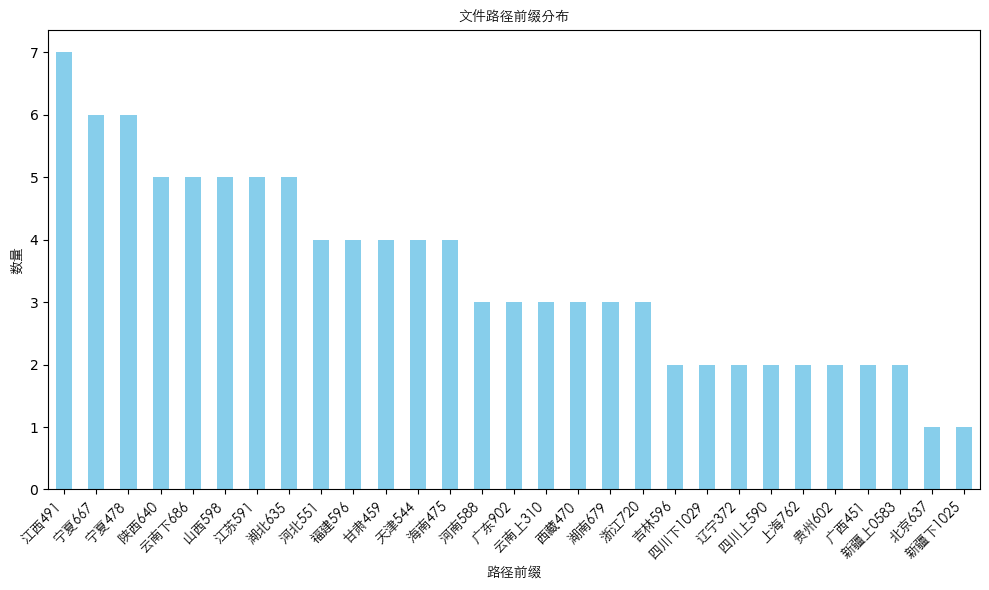

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 加载中文字体
font = FontProperties(fname="/System/Library/Fonts/STHeiti Light.ttc")  # 替换为系统中合适的中文字体路径

# 假设 output_df 已经被定义且包含“文件路径”列
# 提取“文件路径”中第一个“/”之前的部分
output_df['路径前缀'] = output_df['文件路径'].apply(lambda x: x.split('/')[0])

# 统计路径前缀的分布
prefix_counts = output_df['路径前缀'].value_counts()

# 绘制柱状图
plt.figure(figsize=(10, 6))
prefix_counts.plot(kind='bar', color='skyblue')
plt.title('文件路径前缀分布', fontproperties=font)
plt.xlabel('路径前缀', fontproperties=font)
plt.ylabel('数量', fontproperties=font)
plt.xticks(rotation=45, ha='right', fontproperties=font)
plt.tight_layout()
plt.show()

In [46]:
# 统计唯一的路径前缀数量
unique_prefix_count = output_df['文件路径'].apply(lambda x: x.split('/')[0]).nunique()

print("不同路径前缀的数量:", unique_prefix_count)

不同路径前缀的数量: 29


In [80]:
import pandas as pd
from scipy.stats import pearsonr

# 定义要计算相关系数的列组合
column_pairs = [
    ('GPT得分', '与最高得分故事相似度'),
    ('GPT得分', '与伪故事相似度'),
    ('与最高得分故事相似度', '与伪故事相似度')
]

# 遍历列组合并计算相关系数和 p 值
for col1, col2 in column_pairs:
    correlation, p_value = pearsonr(output_df[col1], output_df[col2])

    # 根据 p 值确定显著性标记
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.05:
        significance = '*'
    else:
        significance = ''

    print(f"相关系数 ({col1} 与 {col2}): {correlation:.4f}{significance}")
    print(f"p值 ({col1} 与 {col2}): {p_value:.4e}")

相关系数 (GPT得分 与 与最高得分故事相似度): 0.3610***
p值 (GPT得分 与 与最高得分故事相似度): 2.2470e-04
相关系数 (GPT得分 与 与伪故事相似度): 0.3956***
p值 (GPT得分 与 与伪故事相似度): 4.6183e-05
相关系数 (与最高得分故事相似度 与 与伪故事相似度): 0.6318***
p值 (与最高得分故事相似度 与 与伪故事相似度): 1.8165e-12


In [29]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# 初始化新内容

# 加载模型
model = SentenceTransformer('DMetaSoul/sbert-chinese-general-v2')

# 重新计算相似度
def compute_similarity_with_new_content(file_info):
    _, relative_path = file_info
    file_content = file_contents[relative_path]
    embeddings = model.encode([file_content, new_highest_score_content])
    A, B = embeddings[0], embeddings[1]
    similarity = np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))
    return relative_path, similarity

with ThreadPoolExecutor(max_workers=8) as executor:
    results_with_new_content = list(tqdm(executor.map(compute_similarity_with_new_content, selected_files), 
                                         total=len(selected_files), desc="计算相似度（新内容）"))

# 读取已有结果并添加新相似度列
output_df = pd.read_csv('/Users/zhaorunping/Desktop/Research_Onging/2410_LSE_Xue/result/241027selected_files_similarity_scores.csv')
new_similarity_results = {relative_path: similarity for relative_path, similarity in results_with_new_content}
output_df['相似度_gpt'] = output_df['文件路径'].map(new_similarity_results)

# 保存结果
output_df.to_csv('/Users/zhaorunping/Desktop/Research_Onging/2410_LSE_Xue/result/241027selected_files_similarity_scores.csv', 
                 index=False, encoding='utf-8-sig')


计算相似度（新内容）: 100%|██████████| 100/100 [00:03<00:00, 25.89it/s]


In [30]:
output_df

,文件路径,内容,得分,相似度,相似度_gpt
0,江西491/09983__279花轿顶上为什么要贴个“肃‘字.txt,279.花轿顶上为什么要贴个“肃'‘字\n\n（宜春市）\n\n相传很早以前，有年中秋节，宜...,99,1.000000,NaN
1,江西491/09987__283军峰殿里没有鼓.txt,283.军峰殿里没有鼓\n\n（南丰县）\n\n在所有的道观寺庙中.都会有钟有鼓，唯独南丰军...,96,0.826092,NaN
2,宁夏478/04595__451铁公鸡一毛不拔.txt,451.铁公鸡一毛不拔\n\n（回族?同心县）\n\n过去，有两个结拜弟兄，哥哥叫“铁公鸡”...,27,0.768936,NaN
3,宁夏667/05028__404金手镯儿与铁手铐.txt,404.金手镯儿与铁手铐\n\n〈浬源县）\n\n从前.有个庄户人家，家里是小两口儿和一个婆...,98,0.757677,NaN
4,浙江720/11462__167斯元儒造千柱屋.txt,167.斯元儒造千柱屋\n\n（诸暨县）\n\n斯元儒①欢喜斗富。他斗赢亲家赵万贤之后，心里...,48,0.796678,NaN
...,...,...,...,...,...
95,新疆下1025/09078__0985猎人和狼.txt,"0985.猎人和狼\n\n（蒙古族）\n\n从前,有两个亲密无间的朋友。一个名叫欧布勒代，另...",26,0.644218,NaN
96,江西491/09798__094许真君大战孽龙.txt,094.许真君大战孽龙\n\n（宜春市）\n\n相传.很久很久以前，在薄乡和宜春交界的杨歧山...,70,0.774749,NaN
97,江苏591/09387__272-黑丫头鱼.txt,272-黑丫头鱼\n\n（大丰县）\n\n东洋大海上，有-?种全身乌黑，头顶上有个大洞的鱼....,36,0.723046,NaN
98,山西598/06429__317豆人瓶.txt,317.豆人瓶\n\n（应县）\n\n从前有弟兄仁，父母死后留下不少东西，老大作主均分了，老...,26,0.714334,NaN


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import os

# 读取评分结果
sample_df = pd.read_csv('/content/drive/MyDrive/LSE/02tales_bert_similarity/result/241027sample_scores.csv')
folder = '/content/drive/MyDrive/LSE/02tales_bert_similarity/data'

# 找到得分最高的文件路径和内容
most_superstitious_file_path = sample_df.loc[sample_df['评分'].idxmax(), '文件路径']
with open(os.path.join(folder, most_superstitious_file_path), 'r', encoding='utf-8') as f:
    most_superstitious_file_content = f.read()

# 使用预训练的模型计算相似度
model = SentenceTransformer('DMetaSoul/sbert-chinese-general-v2')

# 读取文件内容的函数
def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()

# 计算相似度的函数
def compute_similarity(file_content):
    embeddings = model.encode([file_content, most_superstitious_file_content])
    A, B = embeddings[0], embeddings[1]
    return np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))

# 保存结果的列表
results_to_save = []
batch_size = 1000  # 每1000条保存一次
file_batch = 1     # 批次编号

# 假设 all_files 是一个包含文件路径的列表，格式为 [(file_path, relative_path), ...]
all_files =   # 请在此处定义你的文件路径列表

# 分批读取和计算相似度
for i in tqdm(range(0, len(all_files), batch_size), desc="Processing batches"):
    file_batch_contents = all_files[i:i + batch_size]  # 获取当前批次的文件
    relative_paths = [relative_path for _, relative_path in file_batch_contents]

    # 使用并行读取文件
    with ProcessPoolExecutor() as executor:
        file_contents = list(tqdm(executor.map(read_file, [file_path for file_path, _ in file_batch_contents]),
                                   desc="Reading files", total=len(file_batch_contents)))

    # 使用并行计算相似度
    with ProcessPoolExecutor() as executor:
        similarities = list(tqdm(executor.map(compute_similarity, file_contents),
                                   desc="计算相似度", total=len(file_contents)))

    # 合并当前批次的结果
    batch_results = [{"文件路径": path, "相似度": sim} for path, sim in zip(relative_paths, similarities)]
    results_to_save.extend(batch_results)

    # 保存结果到CSV文件
    similarity_df = pd.DataFrame(results_to_save)
    save_path = f'/content/drive/MyDrive/LSE/02tales_bert_similarity/result/241027gpt+bert_all_files_similarity_{file_batch}.csv'
    similarity_df.to_csv(save_path, index=False, encoding='utf-8-sig')
    print(f"保存文件至 {save_path}")
    results_to_save.clear()  # 清空列表以便存储下一个批次
    file_batch += 1  # 更新批次编号

# 保存剩余未满1000条的结果
if results_to_save:
    similarity_df = pd.DataFrame(results_to_save)
    save_path = f'/content/drive/MyDrive/LSE/02tales_bert_similarity/result/241027gpt+bert_all_files_similarity_{file_batch}.csv'
    similarity_df.to_csv(save_path, index=False, encoding='utf-8-sig')
    print(f"保存剩余文件至 {save_path}")